In [1]:
import numpy as np
import pandas as pd
import warnings
from scipy.stats import chi2_contingency
from scipy import stats
from matplotlib import pyplot as plt
import json
import yapf.yapflib.yapf_api
from sklearn.utils import shuffle
warnings.filterwarnings("ignore")

1 Read the dataset 
========

In [2]:
maindata= pd.read_csv('DATASET_2019-10-24_light.txt',sep=',')

In [3]:
class0=maindata[maindata.CLASS==0]
class1=maindata[maindata.CLASS==1]
class0=class0.sample(class1.shape[0],random_state=42)
data=pd.concat([class1,class0])
print(data.shape)

data.groupby(by='CLASS').size()

(9482, 407)


CLASS
0    4741
1    4741
dtype: int64

In [4]:

data['FIELD_6_7']=np.min(data[['FIELD_6','FIELD_7']],axis=1) #combine FIELD_6 and FIELD_7 both represent the same thing (Women's marital status)
data=data.drop(columns=['FIELD_6','FIELD_7','COMPARE','B_DAY','Unnamed: 0'])#,'FIELD_1','FIELD_2'
print(data.shape)

(9482, 403)


In [5]:
# # filter the data set
# data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
# data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

# data = data[
#     data.FIELD_15 != 1
# ]  # exclude people who are diagnosed for (high blood pressure)
# data = data[
#     data.FIELD_22 != 1
# ]  # exclude people who are on medication for high blood pressure

# data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
# data = data[
#     data.FIELD_24 != 1
# ]  # exclude people who are on medication for hyperlipidemia

# data = data[data.FIELD_13 != 1]  
# data = data[data.FIELD_20 != 1]  

# print(data.shape)

In [6]:
# rename columns
data.rename(
    columns={
        "L104600": "HBA1C",
        "L103000": "Triglycerides",
        "L100800": "fasting glucose",
        "S000300": "BMI",
        "S000501": "SBP",
        "S000502": "DBP",
        "L101700": "r-GTP gamma",
        "L103300": "Cardiac risk factor",
        "L190400": "Hemoglobin",
        "L190500": "HCT",
        "L100700": "Uric Acid",
        "L101300": "SGPT",
        "L190300": "RBC",
        "L102900": "total cholesterol",
        "L103100": "HDL-Cholesterol",
    },
    inplace=True,
)

In [7]:
# split column types to categorical and numerical
numerical_cols = list(data.columns[~data.columns.str.startswith("FIELD")])
categorical_cols = list(data.columns[data.columns.str.startswith("FIELD")])
categorical_cols.append("CLASS")
numerical_cols.remove("SEX")
categorical_cols.append("SEX")

In [8]:
print(data.shape)
print(data.groupby(by='CLASS').size())

(9482, 403)
CLASS
0    4741
1    4741
dtype: int64


In [9]:
# print(data.shape)
# print(data.groupby(by='CLASS').size())

# mydata=data.copy()
# class1 = mydata[mydata.CLASS == 1]
# class0 = mydata[mydata.CLASS == 0]

# data = pd.concat([class1.sample(class0.shape[0],random_state=42), 
#                   class0])

# print(data.shape)

2 Feature Selection
===========

2.1 Calculate correlation Value - for numerical values
========

2.1.1 Pearson Correlation
======

In [ ]:
corr = data[numerical_cols].corr()  # compute the correlation value
corr = corr.CLASS  # select the correlation values of the Class

# convert correlation values to dataframe
corrvalPD = pd.DataFrame()
corrvalPD["Col"] = corr.index
corrvalPD["val"] = abs(corr.values)

corrvalPD = corrvalPD.sort_values(by="val", ascending=False)
corrvalPD.head()

In [ ]:
# get count of none NA values of each feature set
mydataset = data.copy()[numerical_cols]
colCount = []
for i in mydataset.columns:
    colCount.append([i, mydataset[i].dropna().shape[0]])

colCountPD = pd.DataFrame(colCount, columns=["Col", "Count"])
colCountPD.head()

In [ ]:
# merge the correlation value and the total count of the feature
mergedColCorrCount = pd.merge(
    corrvalPD, colCountPD, how="inner", left_on="Col", right_on="Col"
)
mergedColCorrCount = mergedColCorrCount[mergedColCorrCount.Count > 100000]
mergedColCorrCount = mergedColCorrCount.sort_values(by="val", ascending=False)
mergedColCorrCount.head(20)

In [ ]:
# select top 20 correlated features
print(list(mergedColCorrCount.head(16).Col))

2.1.2 Anova test
=======

In [ ]:
# another option for feature selection of numerical values

mydataset = data.copy()[numerical_cols]  # filter only numrical columns
colslist = mydataset.columns
DiabeticColVals = mydataset.CLASS

cor = []
pval = []
count = []

# for each column compute f and p values
for i in range(len(colslist)):

    temp = pd.DataFrame([])
    temp["a"] = DiabeticColVals
    temp["b"] = mydataset[colslist[i]]
    temp = temp.dropna()

    count.append(temp.shape[0])
    tempcor = temp.corr()

    if tempcor.shape[0] > 1:
        F, p = stats.f_oneway(
            temp[temp["a"] == 0].b, temp[temp["a"] == 1].b
        )
        cor.append(F)
        pval.append(p)
    else:
        cor.append(0)
        pval.append(0)

In [ ]:
FvalPvalCorr = pd.DataFrame()
FvalPvalCorr["Cols"] = colslist
FvalPvalCorr["F"] = cor
FvalPvalCorr["P"] = pval
FvalPvalCorr["Count"] = count
FvalPvalCorr = FvalPvalCorr.sort_values(by="F", ascending=False)

In [ ]:
# select top 20 features
print(list(FvalPvalCorr[FvalPvalCorr.Count > 7000].Cols)[:25])
FvalPvalCorr[FvalPvalCorr.Count > 7000].head(20)

2.2 Correlation for categorical values
============

2.2.1 chi2 method
=====

In [10]:
# rename commen field names
categorical_cols[categorical_cols.index("FIELD_33")] = "_4_1_Smoking"
categorical_cols[categorical_cols.index("FIELD_38")] = "Drinking_5_1_days"
categorical_cols[
    categorical_cols.index("FIELD_40")
] = "_6_1_of_physical_activity_high_strength"
categorical_cols[categorical_cols.index("FIELD_31")] = "Family_history"
categorical_cols[
    categorical_cols.index("FIELD_41")
] = "_6_2_of_physical_activity_moderate"
categorical_cols[categorical_cols.index("FIELD_27")] = "_2_family_history_stroke"
categorical_cols[categorical_cols.index("FIELD_21")] = "_1_medication_heart_disease"
categorical_cols[categorical_cols.index("FIELD_14")] = "Whether_one_diagnosis_disease"
categorical_cols[categorical_cols.index("FIELD_32")] = "_3B_hepatitis"
categorical_cols[
    categorical_cols.index("FIELD_42")
] = "_6_3_of_physical_activity_walking"
categorical_cols[categorical_cols.index("FIELD_4")] = "blood_type"
categorical_cols[categorical_cols.index("FIELD_29")] = "_2_family_history_hypertension"
categorical_cols[categorical_cols.index("FIELD_3")] = "Blood_factor_RH_factor"
categorical_cols[categorical_cols.index("FIELD_19")] = "_1_drug_therapy_stroke"

In [11]:
mydata = data.rename(
    columns={
        "FIELD_33": "_4_1_Smoking",
        "FIELD_38": "Drinking_5_1_days",
        "FIELD_40": "_6_1_of_physical_activity_high_strength",
        "FIELD_31": "Family_history",
        "FIELD_41": "_6_2_of_physical_activity_moderate",
        "FIELD_27": "_2_family_history_stroke",
        "FIELD_21": "_1_medication_heart_disease",
        "FIELD_14": "Whether_one_diagnosis_disease",
        "FIELD_32": "_3B_hepatitis",
        "FIELD_42": "_6_3_of_physical_activity_walking",
        "FIELD_4": "blood_type",
        "FIELD_29": "_2_family_history_hypertension",
        "FIELD_3": "Blood_factor_RH_factor",
        "FIELD_19": "_1_drug_therapy_stroke",
    },
    inplace=True,
)


# mydata=data[categorical_cols] # filter only categorical columns

In [12]:
# filter only categorical columns
mydata = data[categorical_cols]
# remove columns with string values as data type
mydata = mydata.drop(
    columns=[
        "FIELD_8",
        "FIELD_10",
        "FIELD_11",
        "FIELD_12",
        "FIELD_39",'FIELD_37',
        "FIELD_88",
        "FIELD_89",
        "FIELD_109",
        "FIELD_110",
        "FIELD_111",
        "FIELD_70",
        "FIELD_82",
        "FIELD_85",
        "FIELD_91",
        "FIELD_103",
        "FIELD_106",
    ]
)

mydata.head()

,FIELD_1,FIELD_2,Blood_factor_RH_factor,blood_type,FIELD_5,FIELD_9,FIELD_13,Whether_one_diagnosis_disease,FIELD_15,FIELD_16,...,FIELD_134,FIELD_135,FIELD_136,FIELD_137,FIELD_138,FIELD_139,FIELD_140,FIELD_6_7,CLASS,SEX
196,1000482,20141104,NaN,3,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
501,1001277,20130115,NaN,1,1,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
539,1001450,20150819,NaN,1,2,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
633,1001642,20140226,1,2,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
699,1001799,20180421,1,2,NaN,NaN,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0


In [13]:
# Data clean up
mydata = mydata.drop(
    mydata[["Blood_factor_RH_factor"]][mydata[["Blood_factor_RH_factor"]] == "`"]
    .dropna()
    .index
)
mydata = mydata.drop(
    mydata[["Blood_factor_RH_factor"]][mydata[["Blood_factor_RH_factor"]] == "G"]
    .dropna()
    .index
)

mydata = mydata.drop(
    mydata[["blood_type"]][mydata[["blood_type"]] == "."].dropna().index
)
mydata = mydata.drop(mydata[mydata.FIELD_5 == "."].index)


mydata = mydata.drop(mydata[mydata.FIELD_35 == "?"].index)
mydata = mydata.drop(mydata[mydata.FIELD_35 == "."].index)
mydata = mydata.drop(mydata[mydata.FIELD_36 == "."].index)
# mydata = mydata.drop(mydata[mydata.FIELD_37 == "\\"].index)
mydata.head()

# mydata=mydata.drop(mydata[mydata.FIELD_39 == '7+' ].index)
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '5~7'].index)
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '3-4'].index)


mydata = mydata.drop(mydata[mydata.FIELD_95 == "."].index)
mydata.head()

mydata.head()

,FIELD_1,FIELD_2,Blood_factor_RH_factor,blood_type,FIELD_5,FIELD_9,FIELD_13,Whether_one_diagnosis_disease,FIELD_15,FIELD_16,...,FIELD_134,FIELD_135,FIELD_136,FIELD_137,FIELD_138,FIELD_139,FIELD_140,FIELD_6_7,CLASS,SEX
196,1000482,20141104,NaN,3,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
501,1001277,20130115,NaN,1,1,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
539,1001450,20150819,NaN,1,2,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
633,1001642,20140226,1,2,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
699,1001799,20180421,1,2,NaN,NaN,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0


In [ ]:
AllTables = []

# prepare the table indicating the number of entries per class and per each column group
for j in range(len(mydata.columns)):

    columnName = mydata.columns[j]
    print(j, columnName)

    temp = mydata[columnName].dropna().astype(float).unique()
    mytempdata = mydata[[columnName, "CLASS"]].dropna()
    mytempdata[columnName] = mytempdata[columnName].astype(float)
    temptable = []

    sumval = 0

    for i in range(temp.shape[0]):

        temp_i_val = str(temp[i])
        class0_count = mytempdata.query(
            columnName + " == " + (temp_i_val) + " & CLASS == 0"
        ).shape[0]
        class1_count = mytempdata.query(
            columnName + " == " + (temp_i_val) + " & CLASS == 1"
        ).shape[0]

        sumval = sumval + (class0_count + class1_count)

        temptable.append([class0_count, class1_count])

    #     print(sumval,mytempdata.shape[0], mytempdata.shape[0] == sumval)

    if len(temptable) > 1:
        AllTables.append([temptable, columnName, mytempdata.shape[0]])

In [ ]:
# compute the statisitical values
statas = []
for i in range(len(AllTables)):
    #     print(i,AllTables[i][1])
    table = AllTables[i][0]
    stat, p, dof, expected = chi2_contingency(table)
    statas.append(
        [
            AllTables[i][1],
            stat,
            p,
            dof,
            np.sum(table),
            AllTables[i][2],
            AllTables[i][1],
            table,
            expected,
        ]
    )

In [ ]:
# convert the computed status to dataframe
finalstat = pd.DataFrame(
    statas,
    columns=[
        "Name",
        "stat",
        "p",
        "dof",
        "instances",
        "orginal",
        "Name2",
        "table",
        "expected",
    ],
)
finalstat = finalstat[
    finalstat.orginal > 7000
]  # select columns with count at least 200, 000

# sort stat value and select top 20 features
finalstat.stat = finalstat.stat.astype(int)
finalstat = finalstat.sort_values(by="stat", ascending=False)

print(list(finalstat.Name[:15]))
finalstat[["Name", "stat", "instances"]].head(10)

3 Refine the selected numerical and categorical features
====

In [ ]:
data.shape

In [ ]:
# combine the selected columns list from section 2.1.2 and 2.2.1

newColList = [
    'AGE', 'SBP', 'BMI', 'DBP', 'L100400', 'L101400', 'L105200', 'fasting glucose', 'Hemoglobin', 'L100500', 
    'L101200', 'HDL-Cholesterol', 'HCT', 'S001908', 'L504700', 'RBC', 'r-GTP gamma', 'Uric Acid', 'L190000', 
    'SGPT', 'L101600', 'Cardiac risk factor', 'Triglycerides', 'L190900','FIELD_15', 'FIELD_22', 
    'Whether_one_diagnosis_disease', '_1_medication_heart_disease', '_4_1_Smoking', 'SEX', 
    'FIELD_16', 'FIELD_23', '_6_3_of_physical_activity_walking', '_2_family_history_stroke', 
    'FIELD_24', 'FIELD_17', 'blood_type', '_6_2_of_physical_activity_moderate',
    "CLASS"
]

In [ ]:
# mydata = data[newColList].copy()
# for i in mydata.columns:
# #     if(mydata[i].dropna().shape[0] < 100000):
#     print(i,mydata[i].dropna().shape[0])

# print(mydata.dropna().shape[0])

# mydata.head()

In [ ]:
# filter a new data based on the selected columns
mydata = data[newColList].copy().dropna()

print(mydata.shape)
mydata.head()


In [ ]:
x = mydata[
    [
    'AGE', 'SBP', 'BMI', 'DBP', 'L100400', 'L101400', 'L105200', 'fasting glucose', 'Hemoglobin', 'L100500', 
    'L101200', 'HDL-Cholesterol', 'HCT', 'S001908', 'L504700', 'RBC', 'r-GTP gamma', 'Uric Acid', 'L190000', 
    'SGPT', 'L101600', 'Cardiac risk factor', 'Triglycerides', 'L190900','FIELD_15', 'FIELD_22', 
    'Whether_one_diagnosis_disease', '_1_medication_heart_disease', '_4_1_Smoking', 'SEX', 
    'FIELD_16', 'FIELD_23', '_6_3_of_physical_activity_walking', '_2_family_history_stroke', 
    'FIELD_24', 'FIELD_17', 'blood_type', '_6_2_of_physical_activity_moderate'
    ]
]


y = mydata[["CLASS"]]

print(x.shape)
mydata.head()

3.1 ExtraTreesClassifier feature_importances method
========================

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(x, y)

print(
    model.feature_importances_
)  # use inbuilt class feature_importances of tree based classifiers

# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(17).index)

3.2 SelectKBest method
=========

In [ ]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(x, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ["Specs", "Score"]  # naming the dataframe columns

# x=x[x.columns[:15]]
print(list(x.columns[:20]))

3.3 variance inflation factor 
=============

In [ ]:
# this function computes vif value which help us to remove columns with redundant information ( to avoid Multicollinearity)
# Multicollinearity occurs when two or more predictors in the model are correlated and provide redundant information about the response.
# Multicollinearity was measured by variance inflation factors (VIF) and tolerance


def vifcal(inputdata, depcol):
    vifL5 = []
    import statsmodels.formula.api as sm

    xvars = inputdata.drop([depcol], axis=1)
    xvarnames = xvars.columns
    for i in range(0, xvarnames.shape[0]):
        _y = xvars[xvarnames[i]]
        _x = xvars[xvarnames.drop(xvarnames[i])]
        rsq = sm.ols(formula="_y~_x", data=xvars).fit().rsquared
        vif = round(1 / (1 - rsq), 2)
        print(i, ", ", xvarnames[i], " VIF = ", vif)
        if vif < 5:
            vifL5.append(xvarnames[i])
    return vifL5

In [ ]:
# the new columns are selcted from section 3.2
# newcols = vifcal(mydata[['L104600', 'L103000', 'S000300', 'S000501', 'S000502', 'L101700', 'L103300', 'SEX',
#                          'L190400', 'AGE', 'L190500', 'L100700', 'L101300', 'L190300', 'L102900', 'L103100',
#                          'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31','CLASS']],'CLASS')

newcols = vifcal(
    mydata[
        [
            'AGE', 'L100100', #'DBP','SBP', 'HDL-Cholesterol', 
       'Uric Acid', 'BMI', 'L100200', 'r-GTP gamma', 'fasting glucose',
       'L101600', 'L100400', 'SGPT', 'RBC', 'Hemoglobin', 'HCT',
        '_4_1_Smoking','SEX','Drinking_5_1_days', '_6_1_of_physical_activity_high_strength',
            "CLASS",
        ]
    ],
    "CLASS",
)
print(newcols, len(newcols))

# we need to exclude features with vif value >5
# L190400  ,L103300,L190500,L190300,L102900,L103100

3.4 Final Selected Features
======

In [394]:
# based on the out put of section of 3.2 and 3.3 the following features are selected

# finalFeatures = ['AGE', 'BMI',  'L101400', 'fasting glucose', 
#             'HDL-Cholesterol', 'HCT',   'RBC', 'r-GTP gamma', 
#             'Uric Acid', 'L190000', #'L101200', 'SGPT','SBP', 'DBP', 'L504700','S001908','L100400','L105200', 'L100500', 'Hemoglobin', 
#                  'CLASS'
# ]

# finalFeatures = ['_6_3_of_physical_activity_walking','AGE', 'BMI', 'DBP', 'L504700', 'L100400', 'SBP', 'L101400', 'L190900',
#        'HDL-Cholesterol', 'total cholesterol', 'L103200', 'L190000', 'fasting glucose', 'SGPT', 'r-GTP gamma',
#        'L105200', 'L101600',  'Uric Acid', 'Cardiac risk factor', 'Triglycerides',
#                  'CLASS'
# ]

# finalFeatures = ['AGE', 'SBP', 'BMI', 'DBP', 'L101400', 'FIELD_15', 'L100400', 'L190900',
#        'L190000', 'L105200', 'Cardiac risk factor', 'L504700', 'RBC',
#        'HDL-Cholesterol', 'Uric Acid', 'fasting glucose', 'Triglycerides',
#                  'CLASS'
# ]


# finalFeatures = ['_6_3_of_physical_activity_walking','AGE', 'BMI', 'L504700', 'L100400', 'L101400',
#                  'L190900','HDL-Cholesterol', 'total cholesterol', 'L103200', 'L190000', 'fasting glucose', 'SGPT',                 
#                  'r-GTP gamma','L105200', 'L101600',  'Uric Acid', 'Cardiac risk factor', 'Triglycerides',
#                  'DBP', 'SBP', 
#                  'CLASS'
# ]


# finalFeatures = ['_6_3_of_physical_activity_walking','AGE', 'BMI', 'L504700', 'L100400', 
#                  'L190900','L190000', 'Uric Acid',   'DBP', 'SBP', 'SEX',
#                  '_4_1_Smoking', 'Drinking_5_1_days', '_6_1_of_physical_activity_high_strength',
#                  'CLASS'
# ]

finalFeatures = ['AGE', 'BMI', 'FIELD_15', 'L190900',
                 'Cardiac risk factor', 'L504700', 'RBC',
                 'HDL-Cholesterol', 'Uric Acid', 
                 '_4_1_Smoking', 'Drinking_5_1_days', 'SEX','Triglycerides','r-GTP gamma',
#                  'SBP',  'DBP','fasting glucose', 
                 #'L101400', 'L100400', 'L190000', 'L105200', 
                 'CLASS'
]




Classifier Model Test Based on the features 
========

In [395]:
randomseed = 7
mydata = data[finalFeatures].copy().dropna()
print(mydata.shape)
mydata.head()

(6279, 15)


,AGE,BMI,FIELD_15,L190900,Cardiac risk factor,L504700,RBC,HDL-Cholesterol,Uric Acid,_4_1_Smoking,Drinking_5_1_days,SEX,Triglycerides,r-GTP gamma,CLASS
501,46.0,25.4,0.0,13.2,4.0,3.26,4.93,54.0,5.8,2.0,4.0,0.0,88.0,43.0,1
633,47.0,29.2,0.0,13.9,5.4,1.48,5.25,28.0,4.1,3.0,1.0,0.0,277.0,43.0,1
735,48.0,21.5,0.0,13.4,3.0,0.62,4.58,72.0,4.4,1.0,3.0,1.0,94.0,33.0,1
1050,47.0,24.7,0.0,13.5,3.6,0.98,4.69,55.0,4.4,1.0,2.0,0.0,124.0,44.0,1
1759,49.0,28.4,0.0,13.1,5.3,3.70,4.71,37.0,5.5,1.0,1.0,0.0,177.0,44.0,1


In [383]:
class1 = mydata[mydata.CLASS == 1]
class0 = mydata[mydata.CLASS == 0]

print(class1.shape[0],class0.shape[0],)

class1_test = class1.sample(200, random_state=42)
class0_test = class0.sample(200, random_state=42)
test = pd.concat([class1_test, class0_test])
test=shuffle(test)


class1_train = class1.drop(class1_test.index) #.sample( class2_train.shape[0], random_state=randomseed)
class0_train = class0.drop(class0_test.index) #.sample( class2_train.shape[0], random_state=randomseed)
train = pd.concat([class1_train, class0_train])
train=shuffle(train, random_state=42)

3117 3162


In [384]:
# # generate synthetic dataset to overcome class imbalance
# from collections import Counter
# from numpy.random import RandomState
# from sklearn.datasets import make_classification
# from imblearn.over_sampling import SMOTENC

# sm = SMOTENC(random_state=42, categorical_features=[0],k_neighbors=10,sampling_strategy = 0.9)
# X_res, y_res = sm.fit_resample(train.iloc[:,:-1],train.iloc[:,-1])
# print("Resampled dataset samples per class {}".format(Counter(y_res)))

# train=pd.DataFrame(X_res,columns=list(train.columns[:-1]))
# train['CLASS']=y_res

In [385]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=10, criterion='gini')
rf.fit(train.iloc[:, :-1], train.iloc[:, -1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

0.74


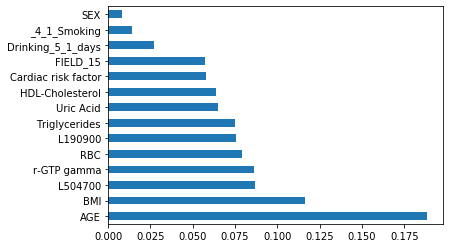

Index(['AGE', 'BMI', 'L504700', 'r-GTP gamma', 'RBC', 'L190900',
       'Triglycerides', 'Uric Acid', 'HDL-Cholesterol', 'Cardiac risk factor',
       'FIELD_15', 'Drinking_5_1_days', '_4_1_Smoking', 'SEX'],
      dtype='object')
1.0


In [386]:
ypred = rf.predict(test.iloc[:, :-1])

score = rf.score(test.iloc[:, :-1], test.iloc[:, -1])
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:, :-1].columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)

print(np.sum(feat_importances.nlargest(16)))

In [387]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test.iloc[:, -1], ypred)

array([[151,  49],
       [ 55, 145]], dtype=int64)

In [388]:
print(
    "Accuracy on training set: {:.3f}".format(
        rf.score(train.iloc[:, :-1], train.iloc[:, -1])
    )
)
print(
    "Accuracy on test set: {:.3f}".format(rf.score(test.iloc[:, :-1], test.iloc[:, -1]))
)
ypred = rf.predict(test.iloc[:, :-1])

confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], ypred))
confmatrx.head()

Accuracy on training set: 0.838
Accuracy on test set: 0.740


,0,1
0,151,49
1,55,145


In [389]:
from sklearn.metrics import classification_report

print(classification_report(test.iloc[:, -1], ypred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       200
           1       0.75      0.72      0.74       200

    accuracy                           0.74       400
   macro avg       0.74      0.74      0.74       400
weighted avg       0.74      0.74      0.74       400



In [390]:
# train.to_csv('train.csv',sep=',')
# test.to_csv('test.csv',sep=',')
# mydata.to_csv('mydata_train_test.csv',sep=',',index=False)

In [391]:
# mydata2 = data[['FIELD_1','FIELD_2','AGE', 'BMI', 'L101400', 'FIELD_15', 'L100400', 'L190900',
#                  'L190000', 'L105200', 'Cardiac risk factor', 'L504700', 'RBC',
#                  'HDL-Cholesterol', 'Uric Acid', 'fasting glucose', 'Triglycerides',
#                  'SBP',  'DBP',
#                  'CLASS'
# ]].copy().dropna()
# mydata2.to_csv('mydata_train_test.csv',sep=',',index=False)

In [392]:
import xgboost as xgb
from sklearn import metrics as m

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=randomseed)

xgb_model.fit(train.iloc[:, :-1], train.iloc[:, -1])

y_pred = xgb_model.predict((test.iloc[:, :-1]))

print(
    "Accuracy on training set: {:.3f}".format(
        xgb_model.score(train.iloc[:, :-1], train.iloc[:, -1])
    )
)
print(
    "Accuracy on test set: {:.3f}".format(xgb_model.score(test.iloc[:, :-1], test.iloc[:, -1]))
)
confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], y_pred))
confmatrx.head()

Accuracy on training set: 0.707
Accuracy on test set: 0.750


,0,1
0,154,46
1,54,146


In [393]:
print(classification_report(test.iloc[:, -1], y_pred))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75       200
           1       0.76      0.73      0.74       200

    accuracy                           0.75       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.75      0.75      0.75       400



In [ ]:
# train.to_csv('datasets/classification/train.txt',sep=',')
# test.to_csv('datasets/classification/test.txt',sep=',')

In [ ]:
# from sklearn.svm import SVC
# clf = SVC(gamma='auto')
# clf.fit(train.iloc[:, :-1], train.iloc[:, -1])


In [ ]:
# ypred=clf.predict((test.iloc[:, :-1]))

# print(
#     "Accuracy on training set: {:.3f}".format(
#         clf.score(train.iloc[:, :-1], train.iloc[:, -1])
#     )
# )
# print(
#     "Accuracy on test set: {:.3f}".format(clf.score(test.iloc[:, :-1], test.iloc[:, -1]))
# )

# confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], y_pred))
# confmatrx.head()

In [ ]:
# print(classification_report(test.iloc[:, -1], ypred))

===============================
==========

In [ ]:

from tensorflow.python.keras import backend as k
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import multi_gpu_model 
from tensorflow.keras.utils import to_categorical

# from keras.models import Sequential
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
model= Sequential()
model.add(Dense(input_dim=21,units=512,activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=512, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))   
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))   
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, activation='softmax', kernel_initializer='uniform'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy' ])

In [ ]:
h=model.fit(train.iloc[:, :-1], train.iloc[:, -1], validation_split=.3,epochs=100, batch_size=200)

In [ ]:
history=h
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()